# Building car price prediction model for CarDekho website

## About project
[CarDekho](https://www.cardekho.com/) is India's leading car search venture that helps users buy cars. Its website and app carry rich automotive content such as expert reviews, detailed specs and prices, comparisons as well as videos and pictures of all car brands and models available in India. The company has tie-ups with many auto manufacturers, more than 4000 car dealers and numerous financial institutions to facilitate the purchase of vehicles.

In this project, we'll collect data about used cars from CarDekho website and use it to build car price prediction model. This model may later be used by CarDekho for suggesting the price of posted by user used car.

In [37]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from math import ceil

# Data Collection

Since we don't have access to the database of CarDekho website, there are two main ways to collect data: find existing datasets or scrape data from CarDekho website. Kaggle contains two useful for our case datasets: [Vehicle dataset](https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho?select=Car+details+v3.csv) (\~8000 rows) and [Used Car Prices in India](https://www.kaggle.com/saisaathvik/used-cars-dataset-from-cardekhocom?select=Cardekho_Extract.csv) (\~20000 rows). We will use this data for model building, because:
* both datasets contain similar columns which will make it easy to union them;
* in sum it is about 28000 rows, which is enough for model building;
* using existing datasets takes less time than scraping new from website;
* according to Kaggle, ~30% of used cars from [Vehicle dataset](https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho?select=Car+details+v3.csv) was bought in 2016-2020 and ~16% of used cars from [Used Car Prices in India](https://www.kaggle.com/saisaathvik/used-cars-dataset-from-cardekhocom?select=Cardekho_Extract.csv) was bought in 2018-2021. Therefore the data is fresh enough.

# Importing the datasets

We'll start by taking a look at first rows and shapes of datasets.

## Vehicle dataset

In [2]:
# read in the data
raw_data_1 = pd.read_csv('Car details v3.csv')

raw_data_1.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [3]:
# check the shape of dataset
raw_data_1.shape

(8128, 13)

Description of fields in Vehicle dataset:
* *name* - name of the car
* *year* - year in which car was first bought
* *selling_price* - selling price of the car
* *km_driven* - number of kilometers the car is driven
* *fuel* - fuel type of the car
* *seller_type* - tells if car is sold by individual or dealer
* *transmission* - gear transmission of the car (Automatic/Manual)
* *owner* - number of previous owners
* *mileage* - mileage of the car
* *engine* - engine capacity of the car
* *max_power* - max power of engine
* *torque* - torque of the car
* *seats* - number of seats in the car

## Used Car Prices in India dataset

In [4]:
# read in the data
raw_data_2 = pd.read_csv('Cardekho_Extract.csv')

raw_data_2.head()

,Source.Name,web-scraper-order,web-scraper-start-url,full_name,selling_price,new-price,year,seller_type,km_driven,owner_type,fuel_type,transmission_type,mileage,engine,max_power,seats
0,cardekho_extract(0-2000).csv,1611917819-1662,https://www.cardekho.com/used-car-details/used...,Maruti Alto Std,1.2 Lakh*,NaN,2012.0,Individual,"1,20,000 kms",First Owner,Petrol,Manual,Mileage19.7 kmpl,Engine796 CC,Max Power46.3 bhp,Seats5
1,cardekho_extract(0-2000).csv,1611918361-1902,https://www.cardekho.com/used-car-details/used...,Hyundai Grand i10 Asta,5.5 Lakh*,New Car (On-Road Price) : Rs.7.11-7.48 Lakh*,2016.0,Individual,"20,000 kms",First Owner,Petrol,Manual,Mileage18.9 kmpl,Engine1197 CC,Max Power82 bhp,Seats5
2,cardekho_extract(0-2000).csv,1611917012-1306,https://www.cardekho.com/used-car-details/used...,Hyundai i20 Asta,2.15 Lakh*,NaN,2010.0,Individual,"60,000 kms",First Owner,Petrol,Manual,Mileage17.0 kmpl,Engine1197 CC,Max Power80 bhp,Seats5
3,cardekho_extract(0-2000).csv,1611917695-1607,https://www.cardekho.com/used-car-details/used...,Maruti Alto K10 2010-2014 VXI,2.26 Lakh*,NaN,2012.0,Individual,"37,000 kms",First Owner,Petrol,Manual,Mileage20.92 kmpl,Engine998 CC,Max Power67.1 bhp,Seats5
4,cardekho_extract(0-2000).csv,1611914861-367,https://www.cardekho.com/used-car-details/used...,Ford Ecosport 2015-2021 1.5 TDCi Titanium BSIV,5.7 Lakh*,New Car (On-Road Price) : Rs.10.14-13.79 Lakh*,2015.0,Dealer,"30,000 kms",First Owner,Diesel,Manual,Mileage22.77 kmpl,Engine1498 CC,Max Power98.59 bhp,Seats5


In [5]:
# check the shape of dataset
raw_data_2.shape

(20026, 16)

Description of fields in Vehicle dataset:
* *Source.Name* - invalid field
* *web-scraper-order* - row id
* *web-scraper-start-url* - url of data source for current row
* *full_name* - name of the car
* *selling_price* - current selling price of used car
* *new-price* - current cost price of brand new car
* *year* - year in which car was first bought
* *seller_type* - type of seller
* *km_driven* - kilometers driven by the car
* *owner_type* - number of previous owners
* *fuel_type* - fuel type of the car
* *transmission_type* - gear transmission of the car (Automatic/Manual)
* *mileage* - mileage of the car
* *engine* - engine capacity of the car
* *max_power* - max horsepower of engine
* *seats* - number of seats in the car

## Dictionary of units in data
* Lakh - a unit in the Indian numbering system equal to one hundred thousand (100,000). In the Indian 2,2,3 convention of digit grouping, it is written as 1,00,000. For example, in India 150,000 rupees becomes 1.5 lakh rupees, written as ₹1,50,000 or INR 1,50,000.
* kmpl - Kilometers Per Litre is a term use to express the fuel efficiency of a vehicle. Fuel efficiency is defined as the ratio of distance travelled per unit of fuel consumed.
* СС - The term “cc” stands for Cubic Centimeters or simply cm³ which is a metric unit to measure the Engine's Capacity or its volume. Usually increase power of car.
* bhp - Traditionally ‘brake horsepower’ (bhp) has been used as the definitive measurement of engine power. It’s distinct from horsepower because it takes into account power loss due to friction – it’s measured by running an engine up to full revs, then letting it naturally slow down to a dead stop.
* nm at rpm - Torque is rotational force, and since an engine relies on a rotating crank to do its work, torque is the force the engine is able to generate. Modern engines generate different levels of torque at different engine speeds (RPMs, or revolutions per minute that the engine is turning through). It’s expressed in Newton-Metres (Nm), and this is what you actually feel when you’re pushed back into your seat on acceleration. A car brochure will indicate the maximum torque the engine is able to generate, and the specific RPM at which it is generated. For instance, the Maruti Dzire generates 113Nm at 4200RPM (petrol) and 190Nm at 2000RPM (diesel). This means the petrol engine produces less torque at a much higher engine speed than the diesel motor, which produces more at a quite low engine speed. The bottom line: Look for a good torque (over 110Nm) with a low RPM (4,000 or so). 1 kgm = 9.80665 Nm

# Data Cleaning

## Plan

We will do data cleaning of both datasets by following next steps:
1. Find corresponding and non-corresponding columns of both datasets.
2. For both datasets separetly:
    * Transform  non-null values of corresponding columns to unified format;
    * Decide if to leave or drop non-corresponding columns.
3. Combine datasets.
4. Manage outliers and null values.

## Find corresponding and non-corresponding columns of both datasets
First of all, let's compare lists of datasets columns.

In [6]:
# for printing list in bullet list style
def bullet_list(lst, header='', sort=True, counter=True):
    if header!='' or counter:
        print(f'{header} ({len(lst)}):')
    if sort:
        lst = sorted(lst)
    for el in lst:
        print('   >', el)

# for finding intercetions and differences between lists of columns
def compare_cols(data_1, data_2, return_flg=False):
    set_1, set_2 = set(data_1.columns), set(data_2.columns)
    inter, diff1, diff2 = set_1.intersection(set_2), set_1.difference(set_2), set_2.difference(set_1)
    bullet_list(inter, 'Corresponding columns')
    bullet_list(diff1, 'Columns from 1st dataset, which are not present in 2nd')
    bullet_list(diff2, 'Columns from 2nd dataset, which are not present in 1st')
    if return_flg:
        return inter, diff1, diff2

In [7]:
compare_cols(raw_data_1, raw_data_2)

Corresponding columns (8):
   > engine
   > km_driven
   > max_power
   > mileage
   > seats
   > seller_type
   > selling_price
   > year
Columns from 1st dataset, which are not present in 2nd (5):
   > fuel
   > name
   > owner
   > torque
   > transmission
Columns from 2nd dataset, which are not present in 1st (8):
   > Source.Name
   > fuel_type
   > full_name
   > new-price
   > owner_type
   > transmission_type
   > web-scraper-order
   > web-scraper-start-url


Fields *fuel, owner, name, transmission* from the 1st dataset actually have corresponding columns with different names in the 2nd dataset (*transmission_type, fuel_type, full_name, owner_type*). We'll change the names of theses fields in the 2nd dataset, so they match with 1st one, and compare again lists of columns.

In [8]:
cols_dict = {
    'fuel_type' : 'fuel',
    'full_name' : 'name',
    'owner_type' : 'owner',
    'transmission_type' : 'transmission'
}
raw_data_2.rename(columns=cols_dict, inplace=True)
inter_cols, diff1_cols, diff2_cols = compare_cols(raw_data_1, raw_data_2, return_flg=True)

Corresponding columns (12):
   > engine
   > fuel
   > km_driven
   > max_power
   > mileage
   > name
   > owner
   > seats
   > seller_type
   > selling_price
   > transmission
   > year
Columns from 1st dataset, which are not present in 2nd (1):
   > torque
Columns from 2nd dataset, which are not present in 1st (4):
   > Source.Name
   > new-price
   > web-scraper-order
   > web-scraper-start-url


This comparison will help us prioritize columns in data cleaning process. Values of corresponding columns will be cleaned and transformed to unified format, since they are present in both datasets. Decision if to clean or drop non-corresponding columns will depend on:
* how hard it is to fill null values in both datasets for this column;
* how significant this column is for future model.

## Data cleaning in the Vehicle dataset

Let's explore data types of fields in 1st dataset.

In [9]:
raw_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


Columns *mileage, engine, max_power* and *torque* have wrong data type (object instead of numeric). In the code cells below, we will convert *mileage, engine, max_power* and *torque* columns to numeric data types. 

In [10]:
raw_data_1.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


### Converting *mileage, engine* and *max_power* to numeric data type

Columns *mileage, engine* and *max_power* have a simpler and identical formats of values (*{value of the field} {unit of the field}*), so we will convert them first.

In [11]:
# first run of code raised error during attemt to convert values to numeric because of one incorrect value in a row
# line of code below added for fixing this value
raw_data_1.loc[raw_data_1['max_power'] == ' bhp', 'max_power'] = np.nan

conv_cols = ['mileage', 'engine', 'max_power']
for name in conv_cols:
    raw_data_1[[name+'_val', name+'_unit']] = raw_data_1[name].str.split(expand=True)
    raw_data_1 = raw_data_1.astype({name+'_val':float})

all_conv_cols = np.array([[name, name+'_val', name+'_unit'] for name in conv_cols]).flatten()
raw_data_1[all_conv_cols].head()

,mileage,mileage_val,mileage_unit,engine,engine_val,engine_unit,max_power,max_power_val,max_power_unit
0,23.4 kmpl,23.40,kmpl,1248 CC,1248.0,CC,74 bhp,74.00,bhp
1,21.14 kmpl,21.14,kmpl,1498 CC,1498.0,CC,103.52 bhp,103.52,bhp
2,17.7 kmpl,17.70,kmpl,1497 CC,1497.0,CC,78 bhp,78.00,bhp
3,23.0 kmpl,23.00,kmpl,1396 CC,1396.0,CC,90 bhp,90.00,bhp
4,16.1 kmpl,16.10,kmpl,1298 CC,1298.0,CC,88.2 bhp,88.20,bhp


Let's check if all values in *mileage, engine, max_power* have same unit and convert them to single unit, if there are more than one.

In [12]:
def check_units(df, origin_cols):
    for name in origin_cols:
        print(f"<======= {name}_unit =======>")
        print(df[name+'_unit'].value_counts())
        print()

In [13]:
check_units(raw_data_1, conv_cols)

<======= mileage_unit =======>
kmpl     7819
km/kg      88
Name: mileage_unit, dtype: int64

<======= engine_unit =======>
CC    7907
Name: engine_unit, dtype: int64

<======= max_power_unit =======>
bhp    7906
Name: max_power_unit, dtype: int64



*mileage* has values with two different units: 'kmpl' and 'km/kg'. Usually, 'kmpl' used for describing cars with petrol or diesel fuel and 'km/kg' - gas fuel. Basically both of them mean *km/unit in which fuel is messured*, so we will replace values in *mileage_unit* with 'kmpu' value (stands for 'km/unit').

In [14]:
raw_data_1['mileage_unit'] = 'kmpu'

Now we are ready to:
* delete *mileage, engine, max_power* and *...\_unit* columns, because we won't need them anymore;
* rename *..._val* columns to *mileage_kmpu, engine_cc, max_power_bhp* and convert them to numeric type of value.

In [15]:
def clear_val_unit_cols(df, cols):
    data = df.copy()
    for name in cols:
        data = data.astype({name+'_val':float})
        # take first value from ..._unit column to add unit as postfix for names of ..._val columns
        data = data.rename(columns={name+'_val' : name+'_'+str.lower(data[name+'_unit'][0])})
        data = data.drop(columns = [name, name+'_unit'])
    
    return data

In [16]:
raw_data_1 = clear_val_unit_cols(raw_data_1, conv_cols)

raw_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   torque         7906 non-null   object 
 9   seats          7907 non-null   float64
 10  mileage_kmpu   7907 non-null   float64
 11  engine_cc      7907 non-null   float64
 12  max_power_bhp  7912 non-null   float64
dtypes: float64(4), int64(3), object(6)
memory usage: 825.6+ KB


As the next step, we'll convert *torque* column to numeric type, so we can analyse its significance for our model later.

### Converting *torque* to numeric data type

Let's start by taking a look at *torque* values again.

In [17]:
raw_data_1['torque'].dropna().head(20)

0               190Nm@ 2000rpm
1          250Nm@ 1500-2500rpm
2        12.7@ 2,700(kgm@ rpm)
3     22.4 kgm at 1750-2750rpm
4        11.5@ 4,500(kgm@ rpm)
5            113.75nm@ 4000rpm
6         7.8@ 4,500(kgm@ rpm)
7                59Nm@ 2500rpm
8          170Nm@ 1800-2400rpm
9               160Nm@ 2000rpm
10              248Nm@ 2250rpm
11               78Nm@ 4500rpm
12              190Nm@ 2000rpm
14               84Nm@ 3500rpm
15         115Nm@ 3500-3600rpm
16              200Nm@ 1750rpm
17    22.4 kgm at 1750-2750rpm
18               62Nm@ 3000rpm
19       219.7Nm@ 1500-2750rpm
20              160Nm@ 2000rpm
Name: torque, dtype: object

*torque* values haven't uniform format and usually containt two values:
* first one is max torque, which car can generate;
* second value is engine speeds, at which car generate specified max torque in first value.

First we will write code for next formats which have been noticed in first 20 values:
* 190Nm@ 2000rpm
* 250Nm@ 1500-2500rpm
* 12.7@ 2,700(kgm@ rpm)
* 22.4 kgm at 1750-2750rpm
* 113.75nm@ 4000rpm

With the help of *try* and *except* blocks we'll find new formats by trial and error method and include them in logic of our parsing code until all values in *torque* will be succesfully parsed.

**Note:**
Full list of different formats in *torque* after trial and error process:
* 190Nm@ 2000rpm
* 250Nm@ 1500-2500rpm
* 12.7@ 2,700(kgm@ rpm)
* 22.4 kgm at 1750-2750rpm
* 113.75nm@ 4000rpm
* 6.1kgm@ 3000rpm
* 250Nm@ 1500~4500rpm
* 96 Nm at 3000 rpm
* 400Nm
* 135 Nm at 2500  rpm (double space between '2500' and 'rpm' + space in the end)
* 96  Nm at 3000  rpm (same as previous + doublespace between '96' and 'Nm')
* 51Nm@ 4000+/-500rpm
* 48@ 3,000+/-500(NM@ rpm)
* 510@ 1600-2400
* 135.4Nm@ 2500
* 210 / 1900
* 400 Nm /2000 rpm
* 380Nm(38.7kgm)@ 2500rpm (occured only in one row, so just added '(38.7kgm)@ ' to delimeters as exception)
* 110(11.2)@ 4800 (occured only in one row, so just added '(11.2)@ ' to delimeters as exception)
* 215Nm@ 1750-3000

In [18]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def split_torque(row):
    """
    Splits 'torque' value in a row and creates 4 new fields: 
    > 'torque_val' - value of car max torque;
    > 'torque_unit' - unit of value in 'torque_val';
    > 'torque_eng_sp_val' - value of engine speed at which car max torque is reached;
    > 'torque_eng_sp_unit' - unit of value in 'torque_eng_sp_val';
    """
    torque_val, torque_unit, torque_eng_sp_val, torque_eng_sp_unit = np.nan, np.nan, np.nan, np.nan
    
    # skip null values
    if row['torque'] is np.nan:
        return torque_val, torque_unit, torque_eng_sp_val, torque_eng_sp_unit
        
    # clear torque value from ',' and tailing ')', split and save in temporary list
    temp = re.split(
        '\(11.2\)@ |\(38.7kgm\)@ |\+\/-500r|\+\/-500\(N|  N| N| r|N|@ r|@ |  r|r|\(k|\(| at |n|-|~| k|k| \/ | \/|\s',
        str(row['torque']).replace(',','').strip(' \)')
    )
    
    # first element of split should be number, helps find cases that should be added in the logic of code
    if is_number(temp[0]):
        torque_val = float(temp[0])
    else:
        print('>>> Error_1:', temp, '\n\n', row, '\n\n\n')
     
    try:
        if is_number(temp[1]):
            torque_eng_sp_val = float(temp[1])
            if len(temp) == 2:
                torque_unit = 'Nm'
                torque_eng_sp_unit = 'rpm'
            elif len(temp) > 2:
                if is_number(temp[2]):
                    torque_eng_sp_val = (float(temp[1])+float(temp[2]))/2
                    torque_unit = 'Nm'
                    torque_eng_sp_unit = 'rpm'
                else:
                    torque_unit = temp[2]
                    torque_eng_sp_unit = temp[3]
        elif len(temp) == 2:
            torque_unit = temp[1]
        elif len(temp) == 3:
            torque_unit = temp[1]
            torque_eng_sp_val = float(temp[2])
            torque_eng_sp_unit = 'rpm'
        elif len(temp) == 4:
            if is_number(temp[3]):
                torque_eng_sp_val = (float(temp[2])+float(temp[3]))/2
                torque_eng_sp_unit = 'rpm'
                torque_unit = temp[1]
            else:
                torque_unit = temp[1]
                torque_eng_sp_val = float(temp[2])
                torque_eng_sp_unit = temp[3]
        elif len(temp) == 5:
            torque_unit = temp[1]
            torque_eng_sp_val = (float(temp[2])+float(temp[3]))/2
            torque_eng_sp_unit = temp[4]
        # else statement helps find cases that should be added in the logic of code
        else:
            print('>>> Error_2:', temp, '\n\n', row, '\n\n\n')
        
        return torque_val, torque_unit, torque_eng_sp_val, torque_eng_sp_unit
    # in case some error is raised during assigning new values, helps find cases that should be added in the logic of code
    except:
        print('>>> Error_3:', temp, '\n\n', row, '\n\n\n')
        
def parse_torque(df):
    data = df.copy()
    
    # split torque
    torque_new_cols = ['torque_val', 'torque_unit', 'torque_eng_sp_val', 'torque_eng_sp_unit']
    data[torque_new_cols] = data.apply(split_torque, axis=1, result_type="expand")
    
    # fix units after spliting
    data['torque_unit'] = data['torque_unit'].replace({
        'm': 'nm',
        'gm': 'kgm',
        'Nm': 'nm',
        'KGM': 'kgm',
        'M': 'nm'
    })
    data['torque_eng_sp_unit'] = data['torque_eng_sp_unit'].replace({
        'pm': 'rpm',
        'RPM': 'rpm'
    })
    
    return data

In [19]:
raw_data_1 = parse_torque(raw_data_1)
raw_data_1[['torque', 'torque_val', 'torque_unit', 'torque_eng_sp_val', 'torque_eng_sp_unit']].head()

,torque,torque_val,torque_unit,torque_eng_sp_val,torque_eng_sp_unit
0,190Nm@ 2000rpm,190.0,nm,2000.0,rpm
1,250Nm@ 1500-2500rpm,250.0,nm,2000.0,rpm
2,"12.7@ 2,700(kgm@ rpm)",12.7,kgm,2700.0,rpm
3,22.4 kgm at 1750-2750rpm,22.4,kgm,2250.0,rpm
4,"11.5@ 4,500(kgm@ rpm)",11.5,kgm,4500.0,rpm


Let's check if all values in *torque_unit, torque_eng_sp_unit* have same unit and convert them to single unit, if there are more than one.

In [20]:
torque_cols = ['torque', 'torque_eng_sp']
check_units(raw_data_1, torque_cols)

<======= torque_unit =======>
nm     7533
kgm     373
Name: torque_unit, dtype: int64

<======= torque_eng_sp_unit =======>
rpm    7872
Name: torque_eng_sp_unit, dtype: int64



We will convert 'kgm' values in *torque_val* to 'nm' (1 kgm = 9.80665 Nm).

In [21]:
raw_data_1.loc[raw_data_1['torque_unit'] == 'kgm', 'torque_val'] = 9.80665 * raw_data_1.loc[raw_data_1['torque_unit'] == 'kgm', 'torque_val']
raw_data_1.loc[raw_data_1['torque_unit'] == 'kgm', 'torque_unit'] = 'nm'
check_units(raw_data_1, ['torque'])
raw_data_1[['torque', 'torque_val', 'torque_unit', 'torque_eng_sp_val', 'torque_eng_sp_unit']].head()

<======= torque_unit =======>
nm    7906
Name: torque_unit, dtype: int64



,torque,torque_val,torque_unit,torque_eng_sp_val,torque_eng_sp_unit
0,190Nm@ 2000rpm,190.000000,nm,2000.0,rpm
1,250Nm@ 1500-2500rpm,250.000000,nm,2000.0,rpm
2,"12.7@ 2,700(kgm@ rpm)",124.544455,nm,2700.0,rpm
3,22.4 kgm at 1750-2750rpm,219.668960,nm,2250.0,rpm
4,"11.5@ 4,500(kgm@ rpm)",112.776475,nm,4500.0,rpm


Let's delete *torque_unit, torque_eng_sp_unit* columns and convert *torque_val, torque_eng_sp_val* to numeric data type.

In [22]:
# dummy column for function
raw_data_1['torque_eng_sp'] = np.nan
raw_data_1 = clear_val_unit_cols(raw_data_1, torque_cols)

raw_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               8128 non-null   object 
 1   year               8128 non-null   int64  
 2   selling_price      8128 non-null   int64  
 3   km_driven          8128 non-null   int64  
 4   fuel               8128 non-null   object 
 5   seller_type        8128 non-null   object 
 6   transmission       8128 non-null   object 
 7   owner              8128 non-null   object 
 8   seats              7907 non-null   float64
 9   mileage_kmpu       7907 non-null   float64
 10  engine_cc          7907 non-null   float64
 11  max_power_bhp      7912 non-null   float64
 12  torque_nm          7906 non-null   float64
 13  torque_eng_sp_rpm  7872 non-null   float64
dtypes: float64(6), int64(3), object(5)
memory usage: 889.1+ KB


Now all columns have right data type and we are ready to explore significance of *torque_nm* and *torque_eng_sp_rpm* columns.

### Exploring significance of *torque_nm* and *torque_eng_sp_rpm* columns for future model

As was mentioned at the start of Data Cleaing section, we will decide if to clean or drop *torque_nm* and *torque_eng_sp_rpm* columns by analising:
1. how hard it is to fill null values in both datasets for this column;
2. how significant this column is for future model.

There are ways to fill null values for these columns:
* in the first dataset there are only 256 null values (~3% of data) in *torque_nm* and *torque_eng_sp_rpm*, so we are able to easiely impute them;
* second dataset don't have such columns. We can collect *torque* values by webscraping with the help of *web-scraper-start-url* column, however it is a time-consuming process. That's the reason why we will first check on existing data if these columns are significant for future model before taking such approach.

To test significance of *torque_nm* and *torque_eng_sp_rpm* columns, we will plot their non-null values with target column 'selling_price' values and calculate Pearson’s and Spearman’s rank correlation coefficients.

In [23]:
def plot_col_signif(df, feat_cols, targ_col, n_rows=1, n_cols=1):
    fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols, figsize=(6*n_cols,4*n_rows), squeeze=False, constrained_layout = True)

    for i in range(n_rows):
        for j in range(n_cols):
            try:
                feat_col = feat_cols[i*n_cols+j]
            except:
                plt.show()
                return
            
            pears_corr = df.corr()[feat_col][targ_col]
            spear_corr = df.corr(method='spearman')[feat_col][targ_col]

            axes[i,j].scatter(df[feat_col], df[targ_col])
            axes[i,j].set_xlabel('feature')
            axes[i,j].set_ylabel('target')
            axes[i,j].set_title(f'Feature: {feat_col}\nPearson\'s r = {pears_corr:.2f}\n Spearman\'s ρ = {spear_corr:.2f}')
            
    plt.show()

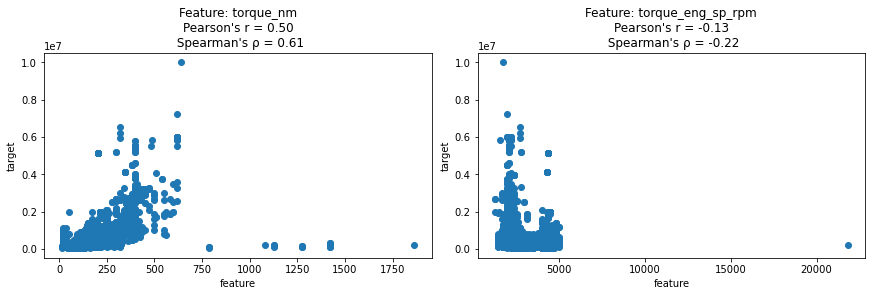

In [24]:
plot_col_signif(raw_data_1, ['torque_nm', 'torque_eng_sp_rpm', 'cost_of_km'], 'selling_price', 1, 2)

*torque_...* columns seem to have outliers, for now we will ignore them.

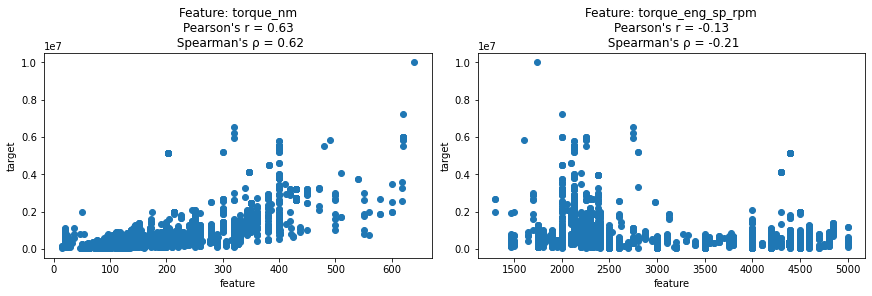

In [25]:
plot_col_signif(raw_data_1[raw_data_1['torque_nm'] < 750], ['torque_nm', 'torque_eng_sp_rpm'], 'selling_price', 1, 2)

*torque_eng_sp_rpm* column has low correlation coefficients, so we can confidently drop it. However *torque_nm* moderately correlated with target column, so let's explore correlation coefficients of *selling_price* and *torque_nm* with other columns.

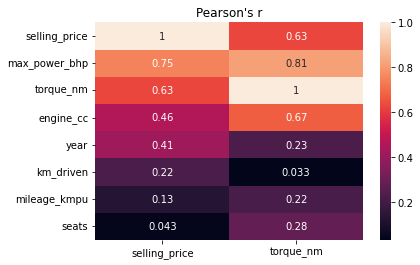

In [26]:
raw_data_1.drop(columns='torque_eng_sp_rpm', inplace=True)

ax = sns.heatmap(
    raw_data_1[raw_data_1['torque_nm'] < 750].corr()[['selling_price', 'torque_nm']].abs().sort_values('selling_price',ascending=False),
    annot=True
)
ax.set_title('Pearson\'s r')
plt.show()

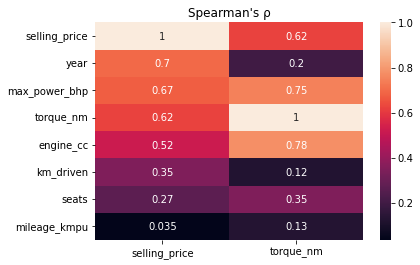

In [27]:
ax = sns.heatmap(
    raw_data_1[raw_data_1['torque_nm'] < 750].corr(method='spearman')[['selling_price', 'torque_nm']].abs().sort_values('selling_price',ascending=False),
    annot=True
)
ax.set_title('Spearman\'s ρ')
plt.show()

Correlation matrixes show that *torque_nm* has one of the highest correlation coefficients with target column in comparison with other features. At the same time it is highly correlated with *max_power_bhp*, which has even higher correlation coefficients with target column. 

Since filling value for *torque_nm* column in second dataset is a time-consuming process and there is a field in the dataset which highly correlates with it, we will drop this column from the first dataset.

In [28]:
raw_data_1.drop(columns='torque_nm', inplace=True)